# Basic SA with FARM

Based on: https://colab.research.google.com/drive/130_7dgVC3VdLBPhiEkGULHmqSlflhmVM  
...with a few modifications to make it work for basic sentiment (valence) classification

### Setup

In [ ]:
# Install FARM
!pip install torch==1.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install farm==0.7.1

In [ ]:
# Here are the imports we need

import torch
from farm.modeling.tokenization import Tokenizer
from farm.data_handler.processor import TextClassificationProcessor
from farm.data_handler.data_silo import DataSilo
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import TextClassificationHead
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.optimization import initialize_optimizer
from farm.train import Trainer
from farm.utils import MLFlowLogger


In [ ]:
# Farm allows simple logging of many parameters & metrics. Let's use the MLflow framework to track our experiment ...
# You will see your results on https://public-mlflow.deepset.ai/
ml_logger = MLFlowLogger(tracking_uri="https://public-mlflow.deepset.ai/")
ml_logger.init_experiment(experiment_name="Public_FARM", run_name="Tutorial1_Colab")


In [ ]:
# We need to fetch the right device to drive the growth of our model
# Make sure that you have gpu turned on in this notebook by going to
# Runtime>Change runtime type and select GPU as Hardware accelerator.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Devices available: {}".format(device))

Devices available: cuda


### Data Handling

In [ ]:
# Here we initialize a tokenizer that will be used for preprocessing text
# This is the BERT Tokenizer which uses the byte pair encoding method.
# It is currently loaded with a German model

tokenizer = Tokenizer.load(
    pretrained_model_name_or_path="bert-base-cased",
    do_lower_case=False)

Now you need to add the "train.tsv" and "test.tsv" files in the "Files" console: 
   
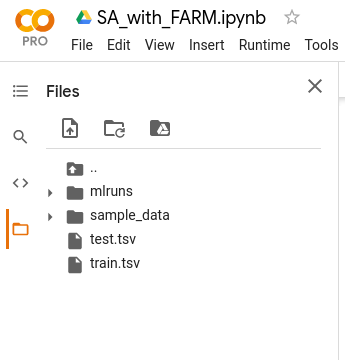

In [ ]:
# In order to prepare the data for the model, we need a set of
# functions to transform data files into PyTorch Datasets.
# We group these together in Processor objects.
# We will need a new Processor object for each new source of data.
# The abstract class can be found in farm.data_handling.processor.Processor

LABEL_LIST = ["Positive", "Negative", "Neutral"]
processor = TextClassificationProcessor(tokenizer=tokenizer,
                                        max_seq_len=128,
                                        data_dir=".",
                                        label_list=LABEL_LIST,
                                        metric="f1_macro",
                                        label_column_name="coarse_label")

In [ ]:
# We need a DataSilo in order to keep our train, dev and test sets separate.
# The DataSilo will call the functions in the Processor to generate these sets.
# From the DataSilo, we can fetch a PyTorch DataLoader object which will
# be passed on to the model.
# Here is a good place to define a batch size for the model

BATCH_SIZE = 32

data_silo = DataSilo(
    processor=processor,
    batch_size=BATCH_SIZE)

### Modeling

In FARM, we make a strong distinction between the language model and prediction head so that you can mix and match different building blocks for your needs.

For example, in the transfer learning paradigm, you might have the one language model that you will be using for both document classification and NER. Or perhaps you have a pretrained language model which you would like to adapt to your domain, then use it for a downstream task such as question answering. 

All this is possible within FARM and requires only the replacement of a few modular components, as we shall see below.

Let's first have a look at how we might set up a model.

In [ ]:
# The language model is the foundation on which modern NLP systems are built.
# They encapsulate a general understanding of sentence semantics
# and are not specific to any one task.

# Here we are using Google's BERT model as implemented by HuggingFace. 
# The model being loaded is a German model that we trained. 
# You can also change the MODEL_NAME_OR_PATH to point to a BERT model that you
# have saved or download one connected to the HuggingFace repository.
# See farm.modeling.language_model.PRETRAINED_MODEL_ARCHIVE_MAP for a list of
# available models

MODEL_NAME_OR_PATH = "bert-base-cased"

language_model = LanguageModel.load(MODEL_NAME_OR_PATH)

In [ ]:
# A prediction head is a model that processes the output of the language model
# for a specific task.
# Prediction heads will look different depending on whether you're doing text classification
# Named Entity Recognition (NER), question answering or some other task.
# They should generate logits over the available prediction classes and contain methods
# to convert these logits to losses or predictions 

# Here we use TextClassificationHead which receives a single fixed length sentence vector
# and processes it using a feed forward neural network. layer_dims is a list of dimensions:
# [input_dims, hidden_1_dims, hidden_2_dims ..., output_dims]

# Here by default we have a single layer network.
# It takes in a vector of length 768 (the default size of BERT's output).
# It outputs a vector of length 2 (the number of classes in the GermEval18 (coarse) dataset)

prediction_head = TextClassificationHead(num_labels=len(LABEL_LIST), class_weights=data_silo.calculate_class_weights(task_name="text_classification"))

In [ ]:
# The language model and prediction head are coupled together in the Adaptive Model.
# This class takes care of model saving and loading and also coordinates
# cases where there is more than one prediction head.

# EMBEDS_DROPOUT_PROB is the probability that an element of the output vector from the
# language model will be set to zero.
EMBEDS_DROPOUT_PROB = 0.1

model = AdaptiveModel(
    language_model=language_model,
    prediction_heads=[prediction_head],
    embeds_dropout_prob=EMBEDS_DROPOUT_PROB,
    lm_output_types=["per_sequence"],
    device=device)

### Training

In [ ]:
# Here we initialize a Bert Adam optimizer that has a linear warmup and warmdown
# Here you can set learning rate, the warmup proportion and number of epochs to train for

LEARNING_RATE = 2e-5
N_EPOCHS = 3

model, optimizer, lr_schedule = initialize_optimizer(
    model=model,
    device=device,
    learning_rate=LEARNING_RATE,
    n_batches=len(data_silo.loaders["train"]),
    n_epochs=N_EPOCHS)

In [ ]:
# Training loop handled by this
# It will also trigger evaluation during training using the dev data
# and after training using the test data.

# Set N_GPU to a positive value if CUDA is available
N_GPU = 1

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    data_silo=data_silo,
    epochs=N_EPOCHS,
    n_gpu=N_GPU,
    lr_schedule=lr_schedule,
    device=device, 
)

In [ ]:
!nvidia-smi

In [ ]:
model = trainer.train()

In [ ]:
# Test your model on a sample (Inference)
from farm.infer import Inferencer
from pprint import PrettyPrinter

infer_model = Inferencer(processor=processor, model=model, task_type="text_classification", gpu=True)

basic_texts = [
    {"text": "Martin is happy"},
    {"text": "Martin is stupid"},
]
result = infer_model.inference_from_dicts(dicts=basic_texts)
PrettyPrinter().pprint(result)
